# Ejemplo para el cálculo de costes de reparacion en el alcance de estudios soluciones clase I: Parte 1 - Lectura de los datos de entrada.

## Importación de paquetes de IPython

In [1]:
# hidden
import environment as env
env.initialize()

In [2]:
# Python 2/3 setup 
from __future__ import (absolute_import, division, print_function, unicode_literals)
# from builtins import *

In [3]:
import os
import sys

In [4]:
# Juypyter setup

%matplotlib inline
import os
import sys
from IPython.display import HTML

## Importación de paquetes para el ejemplo

In [5]:
import logging
import os
import pickle

from reparacion.datos_entrada import datos_entrada_planta
from reparacion.datos_entrada import datos_entrada_diagrama_modos
from reparacion.datos_entrada import datos_entrada_arbol_fallo
from reparacion.datos_entrada import datos_entrada_esquema_division_dique
from reparacion.datos_entrada import datos_entrada_clima_tramos
from reparacion.datos_entrada import datos_entrada_verificacion_dique


from reparacion.calculos import extraccion_resultados
from reparacion.calculos import calculo_costes

from reparacion.datos_entrada import datos_entrada_elementos_reparacion_necesarios
from reparacion.datos_entrada import datos_entrada_elementos_reparacion_disponibles
from reparacion.datos_entrada import datos_entrada_tipo_verificacion





## Datos de entrada de la forma en planta

### RUTA DE DIRECTORIOS DE DATOS DE ENTRADA Y SALIDA


In [6]:
# Ruta con los datos de entrada
ruta_de = os.path.join(env.input_path, 'reparacion', 'estudio_soluciones_clase1')
# Ruta con los datos de salida
ruta_ds = os.path.join(env.output_path, 'reparacion', 'estudio_soluciones_clase1')

### INTRODUCCION

De acuerdo con el articulado de la ROM 1.1. en el alcance de estudio de soluciones de clase I se deben calcular los costes medios de reparación a partir de la información de los agentes en el emplazamiento. Los costes específicos de reparación se determinarán a partir de un diseño de ELU según la configuración del diagrama de modos de fallo del dique. Los costes anuales medios de reparación serán los de reconstrucción del tramo, y se contabilizarán siempre que se incumpla la ecuación de verificación de cualquiera de los modos principales.

El cálculo de los costes se realiza para tres niveles de aproximación o estrategias senciallas:

- **Estrategia de no reparación**: En esta estrategia o nivel de aproximación se podrá considerar que los modos de fallo no se reparan en ningún momento a lo largo de la vida útil de la obra de abrigo. Esta estratgia permitirá comprobar si el dique es capaz de cumplir los condicionantes y requisitos de proyecto sin reparaciones.
- **Estrategia de reparacion inmediata**: En esta estrategia o nivel de aproximación se podrá suponer que el tramo se repara de forma inmediata a la ocurrencia del fallo y recupera sus características estructurales y formales originales. Mediante esta aproximación se contabilizará a partir de las series históricas de los agentes propagadas al emplazamiento y las ecuaciones de verificación e cada uno de los modos del dique el número de veces que falla cada uno de ellos. A partir de esta información y del coste de reconstrucción de cada uno de los modos se obtiene un valor del coste idealizado de reparación del dique a lo largo de la vida útil
- **Estrategia reparacion en tiempo real**: En esta estrategia o nivel de aproximación y con el fin de evaluar la posibilidad de efectuar las operaciones de reparación del dique, se debe especificar el tiempo necesario que debe transcurrir entre que se da la orden de reparar y realmente se inicia la reparación del modo. Además se debe especificar el rendimiento con el que se realiza la reparación. Con esta nueva información se podrá contabilizar el número de veces que se incumplen los criterios de reparación considerados en función del intervalo de tiempo entre ciclos y de los datos de reparación considerados. En esta segunda aproximación, si se desea, se podrán considerar las curvas de acumulación de daño para cada modo y considerar una verificación a ELS.


Se muestra un ejemplo del cálculo de los costes de reparación de un subsistema de un tramo de dique compuesto por tres modos de fallo teóricos. Se describen a continuación los datos de entrada considerados.

### DEFINICIÓN DEL ALCANCE Y ESTRATEGIA

In [7]:
alcance = 'EA'

#estrategia = 'no_reparacion'
#estrategia = 'reparacion_inmediata'
estrategia = 'reparacion_tiempo_real'


### DEFINICIÓN DE LOS DATOS DE ENTRADA

En este ejemplo se propone analizar el coste de un dique de tipo mixto con berma baja de protección (Tipo C, LMB). La sección tipo del dique a analizar se muestra en la figura. En este ejemplo, se considera para la forma en planta un dique compuesto por una única alineación principal de 500 m de longitud. El calado de la alineación principal es de 16 m respecto al nivel medio del mar, la altura de la berma es de 4 m y los cajones tienen una altura de 18 m por 12 m de ancho.

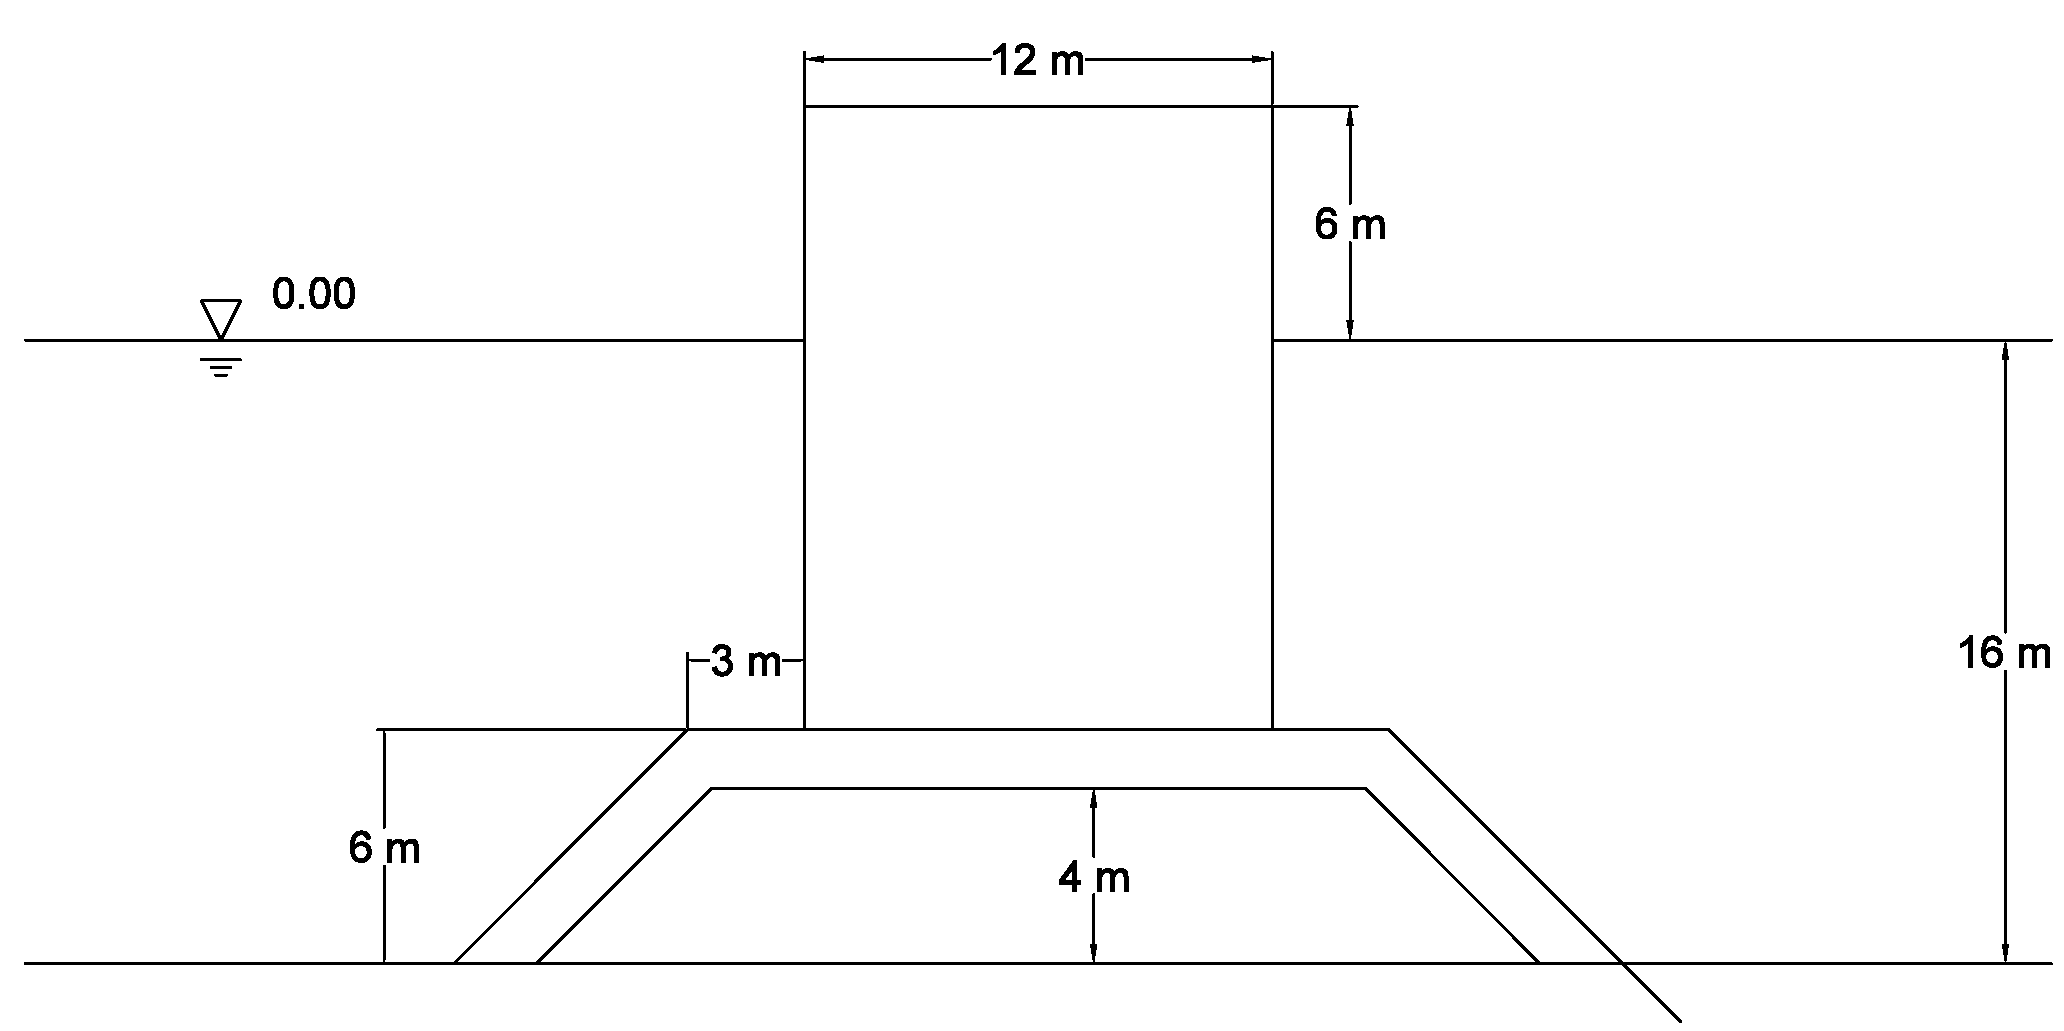

In [8]:
from IPython.display import Image
img_name = os.path.join(ruta_de, 'imagenes', 'esquema_dique_c.png')
Image(filename=img_name, width=800)

#### Lectura de los ficheros con los datos de entrada de tipología y forma en planta
(Para modificar los datos utilizados en el ejemplo se deben modificar los ficheros de la carpeta de inputs)

In [9]:
# Lectura de los datos de entrada en planta
(de_planta) = datos_entrada_planta(ruta_de)
de_planta

longitud  vida_util  calado
T_0     500.0        1.0    16.0

#### Lectura de los ficheros con los datos de entrada del esquema de componentes
De acuerdo con el articulado la estructura jerárquica del dique se descompone en: tramos, subsistemas y modos de fallo. En este ejemplo teórico se muestra el cálculo de costes de un tramo compuesto por un subsistema con tres modos de fallo.

In [10]:
# lectura del esquema de division del dique
(de_esquema_division_dique) = datos_entrada_esquema_division_dique(ruta_de)
de_esquema_division_dique

tramo subsistema modo_fallo
0   T_0       SS_0       MF_1
1   T_0       SS_0       MF_2
2   T_0       SS_0       MF_3

#### Lectura de los ficheros con los datos de entrada del diagrama de componentes
De acuerdo con el articulado de la ROM 1.1. los diagramas de componentes expresan las posibles combinaciones de elementos del espacio de sucesos que suponen el incumplimiento de los requisitos del sistema. Los tipos de diagramas pueden ser: tipo serie (en el que el sistema falla si lo hace al menos uno de los componentes), tipo paralelo (el sistema falla si lo hacen todos los componentes) o tipo mixto (mezcla de ambos).

Para este ejemplo se ha definido un diagrama para cada estructura jerárquica del dique:

- Diagrama de modos del dique: En el que se indican las posibles combinaciones de tramos que deben fallar para considera el fallo del dique. En este ejemplo se considera que el dique falla si falla el tramo $T\_0$.
- Diagrama de modos de los tramos: En el que se indican las posibles combinaciones de subsistemas que deben fallas para considerar el fallo del tramo. En este ejemplo se considera que el tramo falla si falla el subsistema $SS\_0$.
- Diagrama de modos de los subsistemas: En el que se indican las posibles combinaciones de modos que deben fallar para considerar el fallo de un subsistema. Para este ejemplo se ha considerado un diagrama de modo tipo mixto en los que los modos MF\_1 y MF\_2 se encuentran en paralelo y éstos en serie respecto al MF\_3


In [11]:
# Lectura de los datos de entrada del diagrama de modos
(de_diagrama_modos) = datos_entrada_diagrama_modos(ruta_de)
de_diagrama_modos['de_diagrama_modos_dique']

opciones_de_destruccion_total
Dique  op1                       ['T_0']

In [12]:
de_diagrama_modos['de_diagrama_modos_tramos']

opciones_de_destruccion_total
T_0 op1                      ['SS_0']

In [13]:
de_diagrama_modos['de_diagrama_modos_subsistemas']

opciones_de_destruccion_total
T_0 SS_0 op1              ['MF_1', 'MF_2']
         op2                      ['MF_3']

#### Lectura de los datos climáticos

Dentro de la carpeta ’clima’ es necesario que haya una carpeta por cada uno de los tramos
que componen el dique con el nombre de la etiqueta del tramo (en este caso únicamente uno). Dentro de cada carpeta se debe
encontrar un fichero denominado ’clima.txt’ con las series temporales históricas propagadas al
emplazamiento de cada uno de los agentes necesarios para realizar la verificación del dique. Las
series temporales se estructurarán por columnas.

La matriz con los datos de clima tendrán un valor de nivel (respecto al NMM), velocidad de viento, altura de ola, periodo pico, dirección media de procedendia del oleaje y dirección media de procedencia del viento para cada hora.

Se muestra a continuación un ejemplo del fichero de clima:

In [14]:
# Lectura de los datos de clima para cada tramo
(clima_tramos, cadencia) = datos_entrada_clima_tramos(de_esquema_division_dique, de_planta, ruta_de)

# Cambio el numero de filas y columnas que se muestran 
env.pandas_setup(10, 50)
display(clima_tramos['T_0'])
# Cambio el numero de filas y columnas a sus valores por defecto
env.pandas_setup()

nivel        vv        hs         tp          dh          dv  \
0     -0.197452  5.742884  0.412004   7.577019  254.247544  162.987077   
1      0.468996  0.714908  0.821672   8.677967  257.565338  141.477188   
2      0.118437  3.721660  0.199103  10.859557  253.640407  302.096175   
3     -0.533291  2.043294  0.547271   7.138475  251.336751    2.889659   
4     -0.267650  1.815516  0.750617   8.526316  255.215891  165.937557   
...         ...       ...       ...        ...         ...         ...   
29211 -0.030432  2.336437  0.438078   9.457665  237.048698  331.545860   
29212 -0.566616  2.086231  0.446601   9.218670  241.627192  123.033967   
29213 -0.160335  1.285514  0.398538  13.184551  245.040297  358.593331   
29214  0.474897  2.019519  0.403624  11.975245  242.009375  354.965854   
29215  0.042921  3.671009  0.472338  14.473563  247.397039  258.424375   

            mas       mme     calado  
0      1.595942 -0.067649  15.802548  
1      2.258235 -0.063495  16.468996  
2      1.912683 -0.068501  16.118437  
3      1.257457 -0.065004  15.466709  
4      1.521742 -0.063648  15.732350  
...         ...       ...        ...  
29211  1.758231 -0.062919  15.969568  
29212  1.215802 -0.056673  15.433384  
29213  1.630499 -0.065089  15.839665  
29214  2.265278 -0.064636  16.474897  
29215  1.833988 -0.065322  16.042921  

[29216 rows x 9 columns]

#### Lectura de datos de entrada del tipo de verificación para cada modo de fallo
De acuerdo con el Articulado de la ROM 1.1 en el alcance de estudio de soluciones de clase I se deben calcular los costes medios de reparación a partir de un diseño de ELU según la configuración del diagrama de modos de fallo del dique. Por lo tanto dentro de la carpeta 'tipo_verificacion_curva_acum_dano' el fichero 'tipo_verificacion_curva_acum_dano.txt' le indicará a la herramienta que cada modo de fallo se verifica a ELU y por lo tanto los parámetros de la curva de acumulación de daño se fijan a 0. Si se desease realizar una verificación a ELS bastarría con modificar el parámetro a ELS y añadir para cada modo los parámetros a, b y c de curva de acumulación de daño.

Se muestra a continuación un ejemplo con los ficheros de entrada para el tipo de verificación para cada modo de fallo:


In [15]:
# Tipo de verificacion y curva de acumulacion de dano
de_tipo_verificacion = datos_entrada_tipo_verificacion(ruta_de)

de_tipo_verificacion

tipo_diseno  par_a  par_b  par_c
T_0 SS_0 MF_1         elu    0.0    0.0    0.0
         MF_2         elu    0.0    0.0    0.0
         MF_3         elu    0.0    0.0    0.0

Además se debe leer los resultados del módulo de verificación en el que se indica para cada estado de mar de la vida útil si cada uno de los modos de fallo fallan o no fallan

In [16]:
    # Verificacion tramos del dique
    (de_verificacion_tramos, peralte) = datos_entrada_verificacion_dique(ruta_de, de_esquema_division_dique)
    de_verificacion_tramos.loc[:, ('T_0', 'SS_0', 'MF_1')]

0        False
1        False
2        False
3        False
4        False
         ...  
14595    False
14596    False
14597    False
14598    False
14599    False
Name: (T_0, SS_0, MF_1), Length: 14600, dtype: object

#### Lectura de los datos de entrada con la estrategia de reparación
Para cada modo de fallo es necesario especificar: el tiempo medio de espera que debe transcurrir desde que se inicia la orden de reparación hasta que se inician los trabajos de reparación; el rendimiento medio de reparación del modo en (\% de avería reparada / hora) y los costes medios de reparación del modo en ($\geneuro$ / hora).

Es importante remarcar que la herramienta modificará algunos de los parámetros introducidos relacionados con la estrategia de reparación para adapatarlos a la estrategia definida:

- Si la estrategia es de **no reparación**: la herramienta no iniciará los trabajos de reparación en ningún momento independientemente de los parámetros introducidos.
- Si la estrategia es de **reparacion inmediata**: la herramienta considerará disponibilidad infinita de medios y un rendimiento de reparación infinito. De este modo, la herramienta reparará toda la avería en el estado posterior al que se produjo la avería independientemente de los parámetros introducidos.
- Si la estrategia es de **reparacion en tiempo real**: la herramienta considera los tiempos medios de inicio de reparación y rendimientos introducidos por el usuario.

**NOTA IMPORTANTE**
Es importante remarcar que en función de la estrategia elegida, los costes introducidos serán tratados de forma diferentes por la herramienta:
- Si la estrategia es de **no reparación**: No se utilizarán los costes de reparación.
- Si la estrategia es de **reparacion inmediata**: El coste introducido deberá ser el de reconstrucción de todo el modo de fallo. Dicho coste será aplicado por la herramienta cada vez que se repare.
- Si la estrategia es de **reparacion en tiempo real**: En este caso, el coste introducido deberá tener las unidades de $\euro/ hora$. Es el coste total de reparación por cada hora de trabajo.

En este ejemplo se considerán unos tiempos medios teóricos de inicio de reparación de 48, 12 y 24 h. Los rendimientos de reparación teóricos considerados son: 0.1, 0.001 y 0.01 (\% / h) y el coste teórico de reparación de cada modo considerado es de 150 $\geneuro$ / h. Para este alcance no se definen elementos de reparación disponibles en Puerto de forma permanente.

In [17]:
    # Datos de entrada de reparacion necesario
    de_reparacion_necesarios = datos_entrada_elementos_reparacion_necesarios(ruta_de, cadencia, alcance,
                                                                             estrategia)
    # Datos de entrada de reparacion disponibles
    de_reparacion_disponibles = datos_entrada_elementos_reparacion_disponibles(ruta_de, cadencia, alcance)
    
    de_reparacion_necesarios

t_espera_ini_reparacion   rend  costes_reparacion  \
T_0 SS_0 MF_1                     48.0  0.001              150.0   
         MF_2                     12.0  0.010              150.0   
         MF_3                     24.0  0.100              150.0   

               na_umbral_ini_reparacion  na_umbral_fin_reparacion  
T_0 SS_0 MF_1                      0.01                         0  
         MF_2                      0.01                         0  
         MF_3                      0.01                         0

#### Lectura de los datos de entrada de árbol de desencadenamiento y propagación del fallo
En este alcance no es necesario especificar árboles de desencadenamiento y propagación del fallo por lo cual la herramienta automaticamente crea un árbol de desencadenamiento y propagación del fallo vacío.

In [18]:
# Lectura de los datos de entrada de arbol de fallo
(de_arbol_fallo) = datos_entrada_arbol_fallo(alcance, de_esquema_division_dique, ruta_de)

## Guardado de las variables

In [19]:
# Saving the objects:
dir_data = os.path.join(env.data_path, 'reparacion', 'estudio_soluciones_clase1', 'var_co_costes_reparacion_01_es_c1.pkl')

with open(dir_data, 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([ruta_de, ruta_ds, alcance, estrategia, de_planta, de_esquema_division_dique, de_diagrama_modos, clima_tramos, cadencia,
                 de_tipo_verificacion, de_verificacion_tramos, peralte, de_reparacion_necesarios, de_reparacion_disponibles, de_arbol_fallo], f)

Continuar con [Parte 2 - Verificación simultánea de todos los modos de fallo principales a lo largo de la vida útil.](co_costes_reparacion_02_es_c1.ipynb).
